In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import sklearn 
import random as rd 
import numpy as np
import plotly.express as px

In [3]:

# Tamanho do dataset
n = 1000
np.random.seed(42)

# Etapa 1: Geração básica dos dados
df = pd.DataFrame({
    'tipo_valvula': np.random.choice(['MFH-3', 'MFH-5', 'MOFH-3', 'JMFH-5', 'VL/O-3'], size=n),
    'funcao_valvula': np.random.choice(['3/2-way', '5/2-way'], size=n),
    'atuacao': np.random.choice(['Elétrica', 'Pneumática'], size=n),
    'pressao_operacao_bar': np.round(np.random.uniform(0.0, 12.0, size=n), 2),
    'pressao_piloto_bar': np.round(np.random.uniform(0.0, 9.0, size=n), 2),
    'temperatura_ambiente_C': np.round(np.random.uniform(-20, 70, size=n), 1),
    'tempo_acionamento_ms': np.round(np.random.uniform(5, 150, size=n), 1),
    'frequencia_comutacao_Hz': np.round(np.random.uniform(5, 30, size=n), 1),
    'vazao_l_min': np.random.choice([500, 800, 1000, 3700, 4500, 7500], size=n),
    'tamanho_conexao': np.random.choice(['G1/8', 'G1/4', 'G1/2', 'G3/4'], size=n),
    'vedacao': 'Soft',
    'piloto_interno': np.random.choice([True, False], size=n),
    'bobina_festool': np.random.choice([True, False], size=n),
    'ligacao_eletrica_ok': np.random.choice([True, False], size=n),
    'manutencao_realizada': np.random.choice([True, False], size=n),
})

# Etapa 2: Ajustes para manter coerência lógica

# 1. Se a válvula for elétrica, ela precisa ter bobina e ligação elétrica
df.loc[df['atuacao'] == 'Elétrica', 'bobina_festool'] = True
df.loc[df['atuacao'] == 'Elétrica', 'ligacao_eletrica_ok'] = True

# 2. Se a temperatura for < -10 ou > 60, aumenta o tempo de acionamento
cond_temp_extrema = (df['temperatura_ambiente_C'] < -10) | (df['temperatura_ambiente_C'] > 60)
df.loc[cond_temp_extrema, 'tempo_acionamento_ms'] += np.random.uniform(10, 40, size=cond_temp_extrema.sum())

# 3. Frequência muito alta exige tempo de acionamento mais baixo
cond_freq_alta = df['frequencia_comutacao_Hz'] > 25
df.loc[cond_freq_alta, 'tempo_acionamento_ms'] = np.minimum(
    df.loc[cond_freq_alta, 'tempo_acionamento_ms'], np.random.uniform(5, 40, size=cond_freq_alta.sum())
)

# 4. Se não houve manutenção, chance maior de tempo de acionamento elevado
cond_sem_manutencao = df['manutencao_realizada'] == False
df.loc[cond_sem_manutencao, 'tempo_acionamento_ms'] += np.random.uniform(5, 30, size=cond_sem_manutencao.sum())

# 5. Pressões muito baixas (<0.1 bar) são mais prováveis em válvulas pneumáticas
df.loc[df['atuacao'] == 'Pneumática', 'pressao_piloto_bar'] = np.maximum(
    df.loc[df['atuacao'] == 'Pneumática', 'pressao_piloto_bar'], 0.1
)

df.head()


,tipo_valvula,funcao_valvula,atuacao,pressao_operacao_bar,pressao_piloto_bar,temperatura_ambiente_C,tempo_acionamento_ms,frequencia_comutacao_Hz,vazao_l_min,tamanho_conexao,vedacao,piloto_interno,bobina_festool,ligacao_eletrica_ok,manutencao_realizada
0,JMFH-5,5/2-way,Elétrica,8.60,0.66,27.9,58.065002,8.4,4500,G1/4,Soft,True,True,True,False
1,VL/O-3,5/2-way,Pneumática,0.87,5.60,-10.7,20.591719,29.4,1000,G3/4,Soft,False,True,True,True
2,MOFH-3,5/2-way,Elétrica,0.86,8.83,-4.5,41.673291,29.1,500,G1/2,Soft,False,True,True,False
3,VL/O-3,5/2-way,Pneumática,0.15,1.71,31.1,106.673100,9.1,500,G1/8,Soft,True,True,True,False
4,VL/O-3,5/2-way,Elétrica,11.48,7.13,6.7,23.000000,12.5,800,G1/8,Soft,False,True,True,True


In [4]:
# Adiciona a coluna de falha com base em regras técnicas
df['falha'] = (
    (df['temperatura_ambiente_C'] > 60) |
    (df['temperatura_ambiente_C'] < -10) |
    (df['pressao_operacao_bar'] < 0.1) |
    (df['pressao_operacao_bar'] > 10) |
    (df['pressao_piloto_bar'] < 0.1) |
    (df['pressao_piloto_bar'] > 8) |
    (df['tempo_acionamento_ms'] > 100) |
    (df['frequencia_comutacao_Hz'] > 25) |
    (~df['ligacao_eletrica_ok'] & (df['atuacao'] == 'Elétrica')) |
    (~df['bobina_festool'] & (df['atuacao'] == 'Elétrica')) |
    (~df['manutencao_realizada'] & (df['tempo_acionamento_ms'] > 90))
).astype(int)


In [5]:
df.head()

,tipo_valvula,funcao_valvula,atuacao,pressao_operacao_bar,pressao_piloto_bar,temperatura_ambiente_C,tempo_acionamento_ms,frequencia_comutacao_Hz,vazao_l_min,tamanho_conexao,vedacao,piloto_interno,bobina_festool,ligacao_eletrica_ok,manutencao_realizada,falha
0,JMFH-5,5/2-way,Elétrica,8.60,0.66,27.9,58.065002,8.4,4500,G1/4,Soft,True,True,True,False,0
1,VL/O-3,5/2-way,Pneumática,0.87,5.60,-10.7,20.591719,29.4,1000,G3/4,Soft,False,True,True,True,1
2,MOFH-3,5/2-way,Elétrica,0.86,8.83,-4.5,41.673291,29.1,500,G1/2,Soft,False,True,True,False,1
3,VL/O-3,5/2-way,Pneumática,0.15,1.71,31.1,106.673100,9.1,500,G1/8,Soft,True,True,True,False,1
4,VL/O-3,5/2-way,Elétrica,11.48,7.13,6.7,23.000000,12.5,800,G1/8,Soft,False,True,True,True,1


In [6]:
import pandas as pd
import numpy as np

n_extra = 9000
np.random.seed(123)

df_extra = pd.DataFrame({
    'tipo_valvula': np.random.choice(['MFH-3', 'MFH-5', 'MOFH-3', 'JMFH-5', 'VL/O-3'], size=n_extra),
    'funcao_valvula': np.random.choice(['3/2-way', '5/2-way'], size=n_extra),
    'atuacao': np.random.choice(['Elétrica', 'Pneumática'], size=n_extra),
    'pressao_operacao_bar': np.round(np.random.uniform(1.0, 9.5, size=n_extra), 2),
    'pressao_piloto_bar': np.round(np.random.uniform(0.2, 7.9, size=n_extra), 2),
    'temperatura_ambiente_C': np.round(np.random.uniform(-5, 40, size=n_extra), 1),
    'tempo_acionamento_ms': np.round(np.random.uniform(5, 80, size=n_extra), 1),
    'frequencia_comutacao_Hz': np.round(np.random.uniform(5, 24.9, size=n_extra), 1),
    'vazao_l_min': np.random.choice([500, 800, 1000, 3700, 4500, 7500], size=n_extra),
    'tamanho_conexao': np.random.choice(['G1/8', 'G1/4', 'G1/2', 'G3/4'], size=n_extra),
    'vedacao': 'Soft',
    'piloto_interno': np.random.choice([True, False], size=n_extra),
    'bobina_festool': True,  # garantir válvula elétrica válida
    'ligacao_eletrica_ok': True,
    'manutencao_realizada': True
})

df_extra['falha'] = 0  # todas são saudáveis

# Se quiser juntar com o seu dataset original:
df_total = pd.concat([df, df_extra], ignore_index=True)



In [7]:
df["falha"].value_counts()

falha
1    725
0    275
Name: count, dtype: int64

In [8]:
df_total["falha"].value_counts()

falha
0    9275
1     725
Name: count, dtype: int64

In [9]:
import pandas as pd

# Aplica get_dummies apenas nas colunas categóricas automaticamente
df_total = pd.get_dummies(df_total, drop_first=True)


In [11]:
df_total.head()

,pressao_operacao_bar,pressao_piloto_bar,temperatura_ambiente_C,tempo_acionamento_ms,frequencia_comutacao_Hz,vazao_l_min,piloto_interno,bobina_festool,ligacao_eletrica_ok,manutencao_realizada,falha,tipo_valvula_MFH-3,tipo_valvula_MFH-5,tipo_valvula_MOFH-3,tipo_valvula_VL/O-3,funcao_valvula_5/2-way,atuacao_Pneumática,tamanho_conexao_G1/4,tamanho_conexao_G1/8,tamanho_conexao_G3/4
0,8.60,0.66,27.9,58.065002,8.4,4500,True,True,True,False,0,False,False,False,False,True,False,True,False,False
1,0.87,5.60,-10.7,20.591719,29.4,1000,False,True,True,True,1,False,False,False,True,True,True,False,False,True
2,0.86,8.83,-4.5,41.673291,29.1,500,False,True,True,False,1,False,False,True,False,True,False,False,False,False
3,0.15,1.71,31.1,106.673100,9.1,500,True,True,True,False,1,False,False,False,True,True,True,False,True,False
4,11.48,7.13,6.7,23.000000,12.5,800,False,True,True,True,1,False,False,False,True,True,False,False,True,False


In [12]:
df_total[df_total["falha"] == 1]["temperatura_ambiente_C"].value_counts().head()

temperatura_ambiente_C
 39.6    4
 64.1    4
 30.8    4
-14.6    4
 69.3    4
Name: count, dtype: int64

In [13]:

X = df_total.drop(columns = "falha")
y = df_total["falha"]

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=432, stratify= y)


In [16]:
import pandas as pd

# Concatenar treino e teste se quiser padronizar todos
X_train_encoded = pd.get_dummies(X_train)
X_test_encoded = pd.get_dummies(X_test)

# Alinhar colunas (caso o one-hot tenha gerado colunas diferentes)
X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='left', axis=1, fill_value=0)


In [17]:
import xgboost as xgb
modelo = xgb.XGBClassifier(objective='binary:logistic')  # Corrige 'object' → 'objective'
modelo.fit(X_train, y_train)
preds = modelo.predict(X_test)


In [21]:
X_train

,pressao_operacao_bar,pressao_piloto_bar,temperatura_ambiente_C,tempo_acionamento_ms,frequencia_comutacao_Hz,vazao_l_min,piloto_interno,bobina_festool,ligacao_eletrica_ok,manutencao_realizada,tipo_valvula_MFH-3,tipo_valvula_MFH-5,tipo_valvula_MOFH-3,tipo_valvula_VL/O-3,funcao_valvula_5/2-way,atuacao_Pneumática,tamanho_conexao_G1/4,tamanho_conexao_G1/8,tamanho_conexao_G3/4
4380,5.52,6.60,8.7,62.000000,14.2,3700,True,True,True,True,False,False,True,False,True,True,False,False,True
6510,4.30,0.52,1.7,38.100000,6.2,3700,True,True,True,True,True,False,False,False,True,False,False,False,False
216,10.88,2.76,42.7,63.937595,29.5,4500,False,True,True,False,False,False,False,False,True,False,True,False,False
9332,1.04,7.61,19.8,46.500000,12.1,7500,False,True,True,True,False,False,False,False,False,False,False,False,False
955,8.09,8.18,20.0,146.219189,18.9,3700,True,False,False,False,True,False,False,False,False,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1666,5.45,7.60,37.7,52.200000,23.4,1000,False,True,True,True,False,False,False,True,False,False,False,True,False
7220,2.10,6.11,39.3,57.100000,10.1,1000,True,True,True,True,False,False,False,True,False,True,False,False,False
5497,7.55,7.55,21.1,52.900000,16.3,1000,True,True,True,True,False,False,False,False,False,True,False,False,True
5715,1.31,2.07,21.8,69.100000,7.1,500,True,True,True,True,False,True,False,False,False,True,False,True,False


In [18]:
from sklearn.metrics import accuracy_score
acuracia = accuracy_score(y_test, preds)
print(f'A acurácia do modelo é {acuracia:.2%}')


A acurácia do modelo é 99.70%


In [26]:
import joblib 
joblib.dump(modelo, 'modelo_xgboost.pkl')


['modelo_xgboost.pkl']

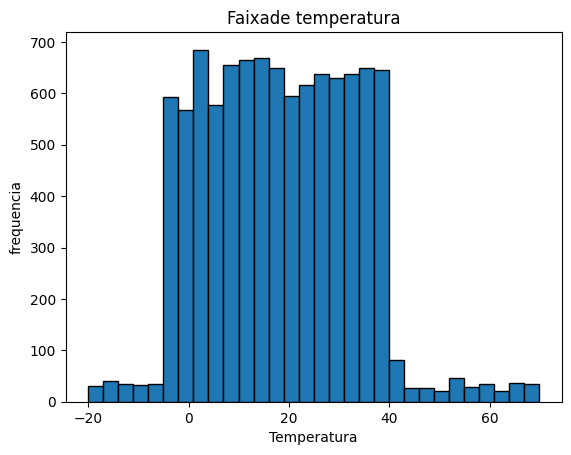

In [23]:
plt.hist(df_total["temperatura_ambiente_C"], bins=30, edgecolor = "black")
plt.title("Faixade temperatura")
plt.xlabel("Temperatura")
plt.ylabel("frequencia")
plt.show()

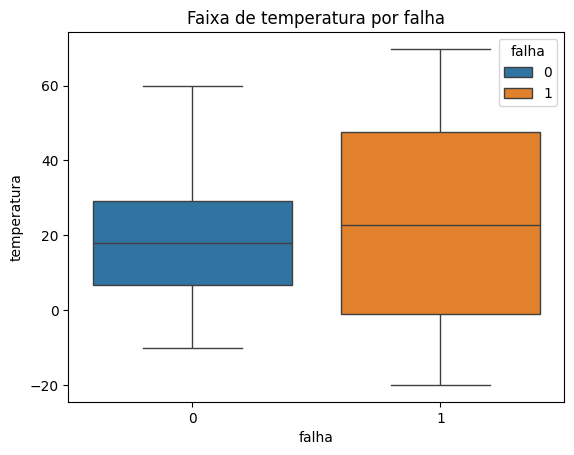

In [20]:
sns.boxplot(data= df_total, y = "temperatura_ambiente_C",x ="falha", hue ="falha")
plt.title("Faixa de temperatura por falha")
plt.xlabel("falha")
plt.ylabel("temperatura")
plt.show()

In [21]:
px.histogram(df_total, x="temperatura_ambiente_C", title = "Distribuição de temperatura")

In [22]:
# Carregar o modelo
modelo_carregado = joblib.load('modelo_xgboost.pkl')

# Fazer previsões novamente com os dados de teste
predicoes = modelo_carregado.predict(X_test)

# Ver resultado
print(predicoes[:10])


[0 0 0 0 0 0 1 0 0 0]


In [23]:
df_total.columns

Index(['pressao_operacao_bar', 'pressao_piloto_bar', 'temperatura_ambiente_C',
       'tempo_acionamento_ms', 'frequencia_comutacao_Hz', 'vazao_l_min',
       'piloto_interno', 'bobina_festool', 'ligacao_eletrica_ok',
       'manutencao_realizada', 'falha', 'tipo_valvula_MFH-3',
       'tipo_valvula_MFH-5', 'tipo_valvula_MOFH-3', 'tipo_valvula_VL/O-3',
       'funcao_valvula_5/2-way', 'atuacao_Pneumática', 'tamanho_conexao_G1/4',
       'tamanho_conexao_G1/8', 'tamanho_conexao_G3/4'],
      dtype='object')

In [1]:
df_total.head()

NameError: name 'df_total' is not defined